# Node embeddings

*   In this lab, we will explore node embeddings. Node embeddings are low-dimensional vectors that represent the nodes in a graph. They can be used for a variety of tasks, such as clustering, classification, and link prediction.

*   We will start by exploring random walks. Random walks are a way of traversing a graph by selecting a node at random and then following one of its neighbors. We will use random walks to generate node sequences, which can then be used to train embedding models.

*   We will then move on to explore deep walk and node2vec. Deep walk and node2vec are two algorithms that can be used to learn node embeddings from random walk sequences. Deep walk uses a recursive neural network to learn the embeddings, while node2vec uses a skip-gram model.

*   Finally, we will explore embedding an entire graph. Embedding an entire graph means learning a vector representation for each node in the graph, such that the vectors capture the structural relationships between the nodes. This can be done using a variety of methods, such as DeepWalk, node2vec, and LINE.

In [120]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import Word2Vec
from sklearn.cluster import KMeans

import random
import time
from typing import Optional, Tuple, Union

from IPython.display import clear_output, display

from karateclub import Estimator

import warnings
warnings.filterwarnings('ignore')


In [55]:
!pip install word2vec

In [56]:
!pip install node2vec

In [57]:
try:
    # Check if Karate Club is installed:
    import karateclub
except ImportError:
    # If Karate Club is not installed, install it.
    %pip install karateclub==1.2.1

In [58]:
G = nx.karate_club_graph()

In [59]:
G.edges

EdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 7), (3, 12), (3, 13), (4, 6), (4, 10), (5, 6), (5, 10), (5, 16), (6, 16), (8, 30), (8, 32), (8, 33), (9, 33), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (18, 32), (18, 33), (19, 33), (20, 32), (20, 33), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 31), (26, 29), (26, 33), (27, 33), (28, 31), (28, 33), (29, 32), (29, 33), (30, 32), (30, 33), (31, 32), (31, 33), (32, 33)])

In [60]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33))

In [87]:
def seed_everything(seed: Optional[int] = None) -> None:
    random.seed(seed)
    np.random.seed(seed)

seed_everything(42)

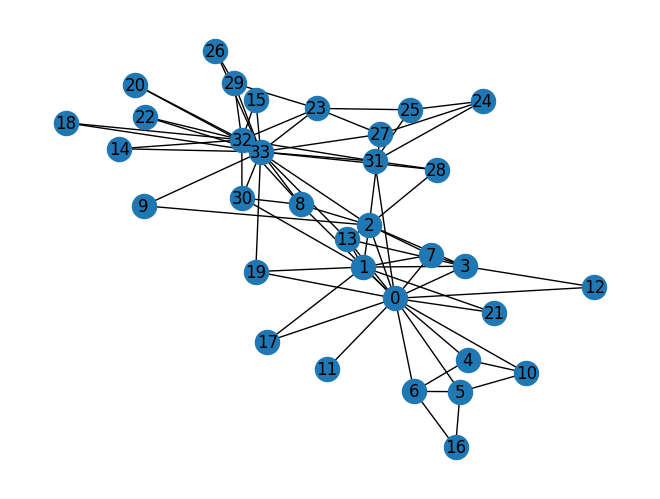

In [61]:
nx.draw(G, with_labels=True)

## Random Walk



*   Starting from vertex $v_{i}$ we obtain its random walk $W_{v_{i}}$
*   Every node will have its set of random walks, a.k.a. stochastic processes with random variables
    \begin{equation}
        W_{v_{i}}^{1}, W_{v_{i}}^{2}, \ldots
    \end{equation}
*   We choose the next vertex $W_{v_{i}}^{k+1}$ from the neighbours of the vertex $W_{v_{i}}^{k}$

A simple random walk can be modeled as follows

\begin{equation}
    P(c_{i}=x \vert c_{i-1}=v)
    =
    \left\lbrace
    \begin{matrix}
    \frac{1}{z}\pi_{vx} & (v,x) \in E \\
    0 & \text{otherwise}
    \end{matrix}
    \right.
\end{equation}

where

*   $c_{i}$ is the $i$-th node in the walk
*   $z$ is a normalization constant
*   $\pi_{vx}$ is an unnormalized transition probability between the nodes $v$ and $x$


## Task: Implementing a Random Walk

In this task, you are required to complete a function that performs a random walk on a graph `G` starting from a given node.

### Instructions:
1. The function `get_random_walk` takes in two parameters:
   - `node`: the starting point of the random walk.
   - `walk_length`: the maximum number of steps to take in the walk.

2. The function should return a list of nodes visited during the random walk. The random walk should stop if there are no unvisited neighbors for the current node.

3. You need to:
   - Create a list to store the nodes visited in the walk (start by adding the starting node).
   - For each step of the walk, select a random unvisited neighbor from the current node’s neighbors.
   - Continue the walk until the walk length is reached or there are no unvisited neighbors.



In [81]:
def get_random_walk(node, walk_length):
    #TODO
    #Write the function to do the Random Walk
    return [2, 3, 12, 0, 10, 4, 6, 5, 16]

In [63]:
get_random_walk(2, 10)

[2, 3, 12, 0, 10, 4, 6, 5, 16]

In [88]:
class RandomWalk:
    def __init__(
        self,
        G: nx.Graph,
        node_size: int = 1500,
        width: int = 2,
        font_size: int = 16,
        fig_size: Tuple[int, int] = (8, 6),
        seed: Optional[int] = 42,
    ) -> None:
        self.G = G
        self.node_size = node_size
        self.width = width
        self.font_size = font_size
        self.fig_size = fig_size
        self.seed = seed

    def _draw(self, ax: plt.Axes) -> None:
        node_colors = [
            "tab:blue"
            if node == self.current_node
            else "tab:orange"
            if node == self.starting_node
            else "tab:gray"
            if node in self.visited_nodes
            else "white"
            for node in self.G.nodes
        ]
        edge_colors = ["tab:gray" if sorted(edge) in self.visited_edges else "black" for edge in self.G.edges]
        pos = nx.spring_layout(self.G, seed=self.seed)

        nx.draw(
            self.G,
            pos=pos,
            ax=ax,
            node_color=node_colors,
            edgecolors="black",
            edge_color=edge_colors,
            node_size=self.node_size,
            width=self.width,
            font_size=self.font_size,
            with_labels=True,
        )

    def run(self, start_node: int, walk_length: int = 5, sleep_seconds: float = 0.5) -> None:
        # Get the random walk sequence from the `get_random_walk` function
        random_walk_sequence = get_random_walk(start_node, walk_length)
        
        # Initialize the starting node and visited nodes/edges
        self.starting_node = random_walk_sequence[0]
        self.current_node = self.starting_node
        self.visited_nodes = [self.current_node]
        self.visited_edges = []
        title = f"Random walk ({walk_length} steps): {self.current_node}"

        fig = plt.gcf()
        ax = fig.gca()
        self._draw(ax)
        plt.title(title, fontsize=self.font_size, loc="left")
        display(fig)
        clear_output(wait=True)

        # Loop over the random walk sequence
        for i in range(1, len(random_walk_sequence)):
            previous_node = self.current_node
            self.current_node = random_walk_sequence[i]
            self.visited_edges.append(sorted((previous_node, self.current_node)))
            self.visited_nodes.append(self.current_node)
            title += f" -> {self.current_node}"

            time.sleep(sleep_seconds)
            self._draw(ax)
            plt.title(title, fontsize=self.font_size, loc="left")
            display(fig)
            clear_output(wait=True)

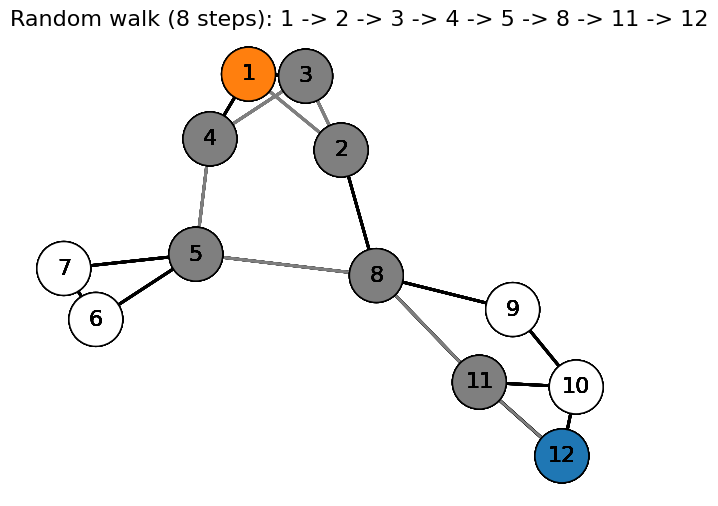

In [96]:
edge_list = [
    (1, 2),
    (1, 3),
    (1, 4),
    (2, 3),
    (2, 8),
    (3, 4),
    (4, 5),
    (5, 6),
    (5, 7),
    (5, 8),
    (6, 7),
    (8, 9),
    (8, 11),
    (9, 10),
    (10, 11),
    (10, 12),
    (11, 12),
]
G = nx.Graph(edge_list)
random_walk = RandomWalk(G)

plt.figure(figsize=(8, 6))
random_walk.run(1, 8)
plt.show()

In [102]:
G = nx.karate_club_graph()

## Task: Generate Multiple Random Walks for Each Node in the Graph

In this task, you will generate random walks from each node in a graph `G` and store the walks for further use. You will perform multiple random walks from each node to capture different structural paths in the graph.

### Task Description:

1. **Graph Traversal with Random Walks**:
   - You will generate `n` random walks starting from every node in the graph `G`.
   - The length of each walk will be set to 10 steps.
   - Use the function `get_random_walk(node, walk_length)` to generate each walk.

2. **Number of Walks per Node**:
   - For each node, you will generate 5 random walks.
   
3. **Storing the Walks**:
   - Store the generated walks in a list called `random_walks`, where each entry represents one random walk starting from a given node.

### Specifications:

- You are given a graph `G` with multiple nodes.
- You must traverse through all nodes in the graph using the `list(G.nodes())` function to retrieve the list of nodes.
- Perform 5 random walks for each node with a maximum walk length of 10.
- Use `tqdm` to visualize the progress of generating walks as the code loops through each node.


In [124]:
all_nodes = ...
number_of_random_walks = ...
random_walks = ...

#TODO
# write the code which will populate the random walk list

In [104]:
len(random_walks)

170

In [105]:
random_walks[0], random_walks[1]

([0, 11], [0, 5, 6, 4, 10])

In [106]:
model = Word2Vec(window = 4,        # Maximum distance between the current and predicted word within a sentence.
                 sg = 1,            # Training algorithm: 1 for skip-gram; 0 for CBOW.
                 hs = 0,            # If 1, hierarchical softmax will be used for model training.
                 negative = 10,     # How many "noise words" should be drawn (usually between 5-20)
                 alpha=0.03,        # The initial learning rate.
                 min_alpha=0.0007,  # Learning rate will linearly drop to min_alpha as training progresses.
    )

model.build_vocab(random_walks, progress_per=2)

In [68]:
model.train(random_walks,
            total_examples = model.corpus_count,
            epochs = 20,
            report_delay = 1)

(3105, 30600)

In [69]:
print(model)

Word2Vec<vocab=9, vector_size=100, alpha=0.03>


In [70]:
model.wv.vectors.shape

(9, 100)

In [71]:
model.wv.vectors[:, 8]

array([-0.25087175, -0.24534124, -0.24977441, -0.23508158, -0.24767518,
       -0.24837601, -0.24648884, -0.2501827 , -0.24853788], dtype=float32)

In [72]:
# most similar nodes to node '1'
for node, v in model.wv.most_similar(1):
    print(node, v, True if node in G.neighbors(1) else False)

6 0.9982342720031738 False
4 0.9981748461723328 False
3 0.9981400966644287 True
10 0.997999906539917 False
0 0.9977157115936279 True
12 0.9976567029953003 False
16 0.9974740743637085 False
2 0.9973062872886658 True


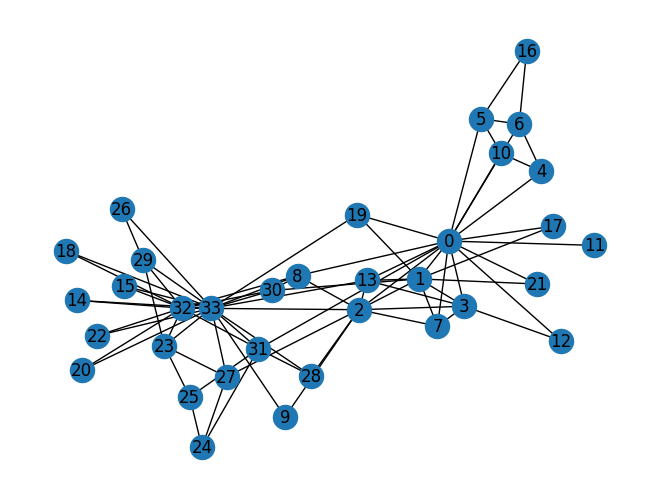

In [79]:
nx.draw(G, with_labels=True)

In [74]:
for v in G.neighbors(1):
    print(v)

0
2
3
7
13
17
19
21
30


In [75]:
labels = KMeans(n_clusters=3, random_state=0).fit_predict(model.wv.vectors)
color_map = plt.get_cmap("tab10")
node_colors = [color_map(label) for label in labels]

In [76]:
def plot_nodes(word_list):

    X = model.wv[word_list]

    # reduce dimensions
    pca_1d = PCA(n_components=1)
    pca_2d = PCA(n_components=2)
    pca_3d = PCA(n_components=3)
    result_1d = pca_2d.fit_transform(X)
    result_2d = pca_2d.fit_transform(X)
    result_3d = pca_3d.fit_transform(X)

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    ax[0].set_axis_off()
    ax[0] = fig.add_subplot(1, 3, 1)
    labels = KMeans(n_clusters=3, random_state=0).fit_predict(result_1d)
    color_map = plt.get_cmap("tab10")
    node_colors = [color_map(label) for label in labels]
    ax[0].scatter([0 for element in range(len(result_1d))], result_1d[:,0], color=node_colors)
    ax[0].set_xlim()

    ax[1].set_axis_off()
    ax[1] = fig.add_subplot(1, 3, 2)
    labels = KMeans(n_clusters=3, random_state=0).fit_predict(result_2d)
    color_map = plt.get_cmap("tab10")
    node_colors = [color_map(label) for label in labels]
    ax[1].scatter(result_2d[:, 0], result_2d[:, 1], color=node_colors)

    ax[2].set_axis_off()
    ax[2] = fig.add_subplot(1, 3, 3, projection='3d')
    labels = KMeans(n_clusters=3, random_state=0).fit_predict(result_3d)
    color_map = plt.get_cmap("tab10")
    node_colors = [color_map(label) for label in labels]
    ax[2].scatter(result_3d[:, 0], result_3d[:, 1], result_3d[:, 2], color=node_colors)
    ax[2].view_init(elev=10., azim=30)
    # for i, word in enumerate(word_list):
    #     ax[2].text(result_3d[i, 0], result_3d[i, 1], result_3d[i, 2], word)


    plt.show()

In [77]:
numbers = list(G.nodes)

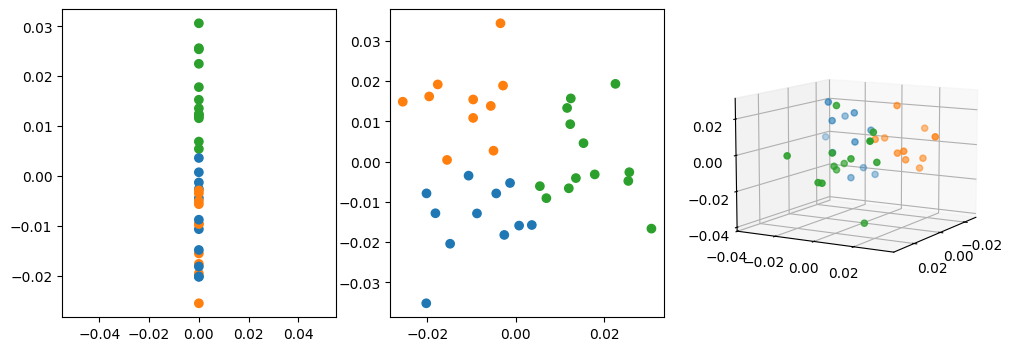

In [107]:
plot_nodes(numbers)

## Let's try another approach

We are looking for a function $f$ such that transforms every node $u$ in the graph $G$ into a vector representation $z_{u}$ in the embedding space $\mathbb{R}^{d}$

\begin{equation}
    f(u) = z_{u}
\end{equation}


**Spoiler**: This function is to be learned from the graph $G$ and is parameter-dependent




In [108]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec

In [112]:
node2vec = Node2Vec(G, dimensions=128, walk_length=40, num_walks=100, workers=2)

Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 50/50 [00:00<00:00, 624.27it/s]


In [110]:
model = node2vec.fit(window=10, min_count=1)

In [111]:
# Get the vector of node '1'
model.wv.get_vector(1)

array([-2.65103541e-02, -3.87614779e-02,  1.02384187e-01, -1.51969120e-01,
       -8.20101332e-03, -1.38329431e-01, -7.54640922e-02,  4.67075743e-02,
        7.86910504e-02,  1.30387321e-01,  3.49389225e-01,  8.93071201e-03,
        2.41900999e-02, -8.23329762e-02, -7.79285952e-02, -6.16323464e-02,
       -6.95053441e-03,  1.44889086e-01,  2.19909251e-02, -1.56961754e-03,
        7.46839568e-02, -1.78177357e-02,  6.20039180e-02, -9.40981507e-02,
       -7.41610229e-02,  1.27397813e-02, -1.15816720e-01, -8.04087706e-03,
        8.98021013e-02,  5.74923977e-02, -1.45049185e-01,  1.09345458e-01,
       -9.66743529e-02,  3.56853493e-02,  2.72058044e-02,  5.36289737e-02,
        2.35875353e-01,  1.12616248e-01,  2.17571989e-01, -1.02506608e-01,
        9.85378996e-02,  6.57446310e-02, -2.86412351e-02, -1.50509432e-01,
        2.98690647e-02, -2.70327600e-03, -4.70309369e-02, -2.44812906e-01,
        1.47307711e-02,  5.30242622e-02,  1.38064638e-01, -5.80394343e-02,
       -1.10768499e-02,  

In [113]:
# most similar nodes to node '1'
for node, _ in model.wv.most_similar(1):
    print((node, _))

('17', 0.8114776015281677)
('11', 0.7987606525421143)
('4', 0.7881738543510437)
('21', 0.771515965461731)
('13', 0.7600378394126892)
('1', 0.7586494088172913)
('7', 0.7575352191925049)
('6', 0.7526553869247437)
('19', 0.7401134967803955)
('10', 0.7397918105125427)


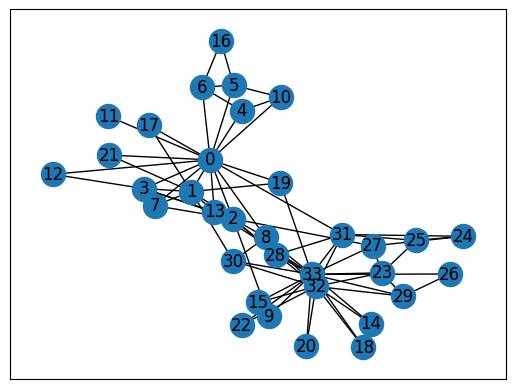

In [114]:
# verify the most similar nodes generated by node2vec from the graph
nx.draw_networkx(G)

In [115]:
# Retrieve node embeddings
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = model.wv.vectors

In [60]:
print(node_ids)
print(node_embeddings)

['33', '0', '32', '2', '1', '31', '23', '3', '13', '8', '5', '6', '25', '7', '29', '27', '30', '4', '10', '16', '15', '24', '26', '28', '22', '19', '14', '12', '21', '20', '11', '17', '9', '18']
[[ 0.03443329 -0.03053874  0.10444838 ... -0.10257997 -0.01751216
   0.00158894]
 [-0.08248031  0.11164988  0.16847241 ... -0.16499694 -0.09129093
  -0.09170694]
 [ 0.10531113 -0.06704495  0.06273142 ... -0.16333692 -0.00180623
   0.03252666]
 ...
 [-0.05109089  0.04118709  0.19318059 ... -0.25868177 -0.03685426
  -0.15528513]
 [ 0.06532764  0.00491784  0.095156   ... -0.13762051  0.0508202
  -0.08113493]
 [ 0.16861849 -0.01229147  0.1930741  ... -0.133867    0.01497915
  -0.0661424 ]]


In [116]:
node_embeddings.shape

(34, 128)

## But how does it Actually work?
### How should we randomly walk?

In [121]:
def node_embedding_method_example(
    G: nx.Graph,
    model: Estimator,
    n_clusters: int = 4,
    node_size: int = 300,
    font_size=16, seed:
    Optional[int] = 42
) -> None:

    #Todo
    # fit the model given on a copy of G
    # get the embeddings from the model
    # fit a KMeans model on the embeddings and predict the labels

    pos = nx.spring_layout(G, seed=seed)
    cmap = plt.get_cmap("tab10")
    node_colors = [cmap(label) for label in labels]

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
    ax.set_axis_off()
    ax = fig.add_subplot(1, 1, 1)
    nx.draw(G, pos=pos, node_color=node_colors, node_size=node_size, with_labels=True, ax=ax)
    plt.title(
        f"Colored nodes based on clusters identified by K-Means (K={n_clusters})\n on embeddings extracted with "
        f"{type(model).__name__}",
        fontsize=font_size,
    )
    plt.show()

## DeepWalk



In the DeepWalk approach our function $f$ is given by the linear transformation, whose $i$-th column has the vector representation for the $u_{i}$ node

\begin{equation}
    f(u_{i})
    =
    W_{\left\vert V\right\vert\times d}I_{i}
\end{equation}

for example

\begin{equation}
    \text{Embedding}
    =
    \begin{pmatrix}
        1 & 2 & 3 \\
        4 & 5 & 6 \\
        7 & 8 & 9 \\
    \end{pmatrix}
    \quad
    I_{2}
    =
    \begin{pmatrix}
        0 \\
        1 \\
        0 \\
    \end{pmatrix}
    \quad
    \text{Embedding}I_{2}
    =
    \begin{pmatrix}
        2 \\
        5 \\
        8 \\
    \end{pmatrix}
\end{equation}

so we get the embedding of the second node


How does the model work?

*   The probability of visiting the vertex $v_{i}$ given the all the previous vertices visited so far $v_{1}$, $v_{2}$, $\ldots$, $v_{i-1}$ in the random walk

    \begin{equation}
        P\left(v_{i} \vert v_{1}, v_{2}, \ldots, v_{i-1} \right)
        \quad
        \mapsto
        \quad
        P(v_{i} \vert f(v_{1}), f(v_{2}), \ldots, f(v_{i-1}) )
        \quad
        \approx
        \quad \texttt{Word2Vec(CBOW)}
    \end{equation}

*   The **problem** is that the random walks can grow and the probability can be expensive to compute, so we can do it conversely

    \begin{equation}
        P\left(v_{1}, v_{2}, \ldots, v_{i-1} \vert v_{i} \right)
        \quad
        \mapsto
        \quad
        P(v_{1}, v_{2}, \ldots, v_{i-1} \vert f(v_{i}) )
        \quad
        \approx
        \quad \texttt{Word2Vec(Skip-Gram)}
        \quad
        \checkmark
    \end{equation}

* Recall that $\texttt{Word2Vec}$ consists of two internal architectures (image taken from [here](https://www.google.com/url?sa=i&url=https%3A%2F%2Ftowardsdatascience.com%2Fsoftmax-activation-function-explained-a7e1bc3ad60&psig=AOvVaw00ynwi60C0CbWKt5hiNxom&ust=1695130330971000&source=images&cd=vfe&opi=89978449&ved=0CBMQ3YkBahcKEwjo2tTforSBAxUAAAAAHQAAAAAQAw))

    ![Word2Vec](https://www.researchgate.net/profile/Wang-Ling-16/publication/281812760/figure/fig1/AS:613966665486361@1523392468791/Illustration-of-the-Skip-gram-and-Continuous-Bag-of-Word-CBOW-models.png)

*   Just in case, the probability function is given by (assuming independent probabilities)

    \begin{equation}
        P(\left\lbrace v_{i-w}, \ldots, v_{i+w} \right\rbrace \vert f(v_{i}) )
        =
        \prod_{j=i-w, i \neq j }^{i+w} P(v_{j} \vert f(v_{i}))
    \end{equation}

*   Recall also that the softmax function returns the probabilities (image taken from [here](https://seed9d.github.io/hierarchical-softmax-in-word2vec/))

    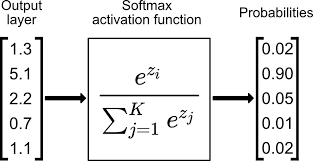

*   Now we need the loss function to train the algorithm

    \begin{equation}
        \min_{f} \left\lbrace
            P(\left\lbrace v_{i-w}, \ldots, v_{i+w} \right\rbrace \vert f(v_{i}) )
        \right\rbrace
    \end{equation}


In [117]:
from karateclub import DeepWalk

G = nx.karate_club_graph()

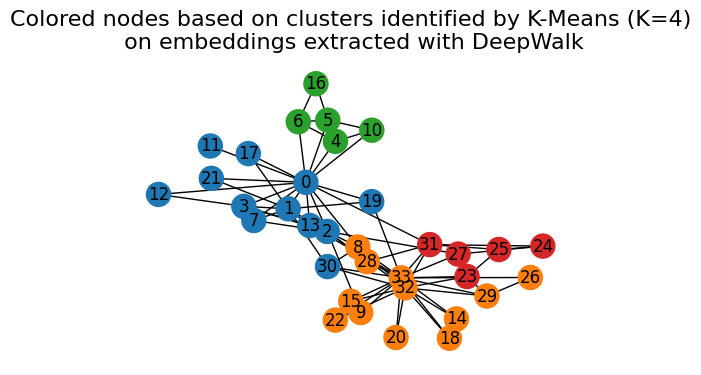

In [125]:
node_embedding_method_example(G, DeepWalk(dimensions=16))

## Node2Vec



> As with the DeepWalk approach, $\texttt{Node2Vec}$ also consists in a linear function $f$, whose $i$-th column has the vector representation for the $u_{i}$ node

\begin{equation}
    f(u_{i})
    =
    W_{\left\vert V\right\vert\times d}I_{i}
\end{equation}

How does the model work?

*   We keep the skip-gram approach with the random walks, but this time however we slightly modify the node sampling strategy so that it is neighbourhood-dependent

    ![SamplingStrategy](https://www.researchgate.net/profile/Melania-Berbatova/publication/353411035/figure/fig4/AS:1048721370402833@1627046067712/Difference-between-BFS-and-DFS-sampling-strategies-12.ppm)

    * **Breath-First Sampling** (BFS): Good for structural equivalence, bad for exploration
    * **Deep First Sampling** (DFS): Good for communities (homophily), bad due to excesive exploratory distance
    


*   Since the sample strategy changes, our transition probability changes

    \begin{equation}
        \pi_{vx}
        =
        \alpha_{pq}(t,x)
        \cdot
        w_{vx}
        \quad
        \text{where}
        \quad
        \alpha_{pq}(t,x)
        =
        \left\lbrace
        \begin{matrix}
        \frac{1}{p} & d(t,x) = 0 \\
        1 & d(t,x) = 1 \\
        \frac{1}{q} & d(t,x) = 2 \\
        \end{matrix}
        \right.
        \quad
        \text{and}
        \quad
        w_{vx} = w_{vx}(=1)
    \end{equation}

    ![TransitionProbability](https://www.researchgate.net/profile/Melania-Berbatova/publication/353411035/figure/fig5/AS:1048721370398723@1627046067822/Illustration-of-the-random-walk-procedure-in-node2vec12.ppm)

    *   $p$ acts as the control for going backard, a.k.a the return parameter
    *   $q$ acts as the control for going forward, a.k.a. the continue parameter or in-out parameter
    
        \begin{equation}
            q>1: \text{local} \quad q<1: \text{global}
        \end{equation}

    *   What about global and local? Sure, modifying the paremters allows to approximately interpolate BFS and DFS


*   The probability function is similar as in the previous case

    \begin{equation}
        P( N_{S}(u) \vert f(u) )
        =
        \prod_{n_{i} \in N_{S}(u)} P(n_{i} \vert f(u))
    \end{equation}

*   The optimization problem is similar as in the DeepWalk model

    \begin{equation}
        \max_{f} \left\lbrace
            P( N_{S}(u) \vert f(u) )
        \right\rbrace
    \end{equation}

**Edge Features**

In case we want to parametrize features associated to any particular edge $(u,v)$ in the graph $G$ there are varios methods to do it:

*   Average distance

\begin{equation}
    \left[f(u) \oplus f(v) \right]_{i}
    =
    \frac{1}{2}\left( f_{i}(u) + f_{i}(v) \right)
\end{equation}

*   Hadamard distance

\begin{equation}
    \left[f(u) \odot f(v) \right]_{i}
    =
    f_{i}(u) * f_{i}(v)
\end{equation}

*   Weighted $L_{1}$ distance

\begin{equation}
    \left\vert \left\vert f(u) \oplus f(v) \right\vert \right\vert_{\bar{1}i}
    =
    \left\vert f_{i}(u) - f_{i}(v) \right\vert
\end{equation}

*   Weighted $L_{2}$ distance

\begin{equation}
    \left\vert \left\vert f(u) \oplus f(v) \right\vert \right\vert_{\bar{2}i}
    =
    \left\vert f_{i}(u) - f_{i}(v) \right\vert^{2}
\end{equation}

# Embedding Entire Graphs

In [45]:
from karateclub import Node2Vec

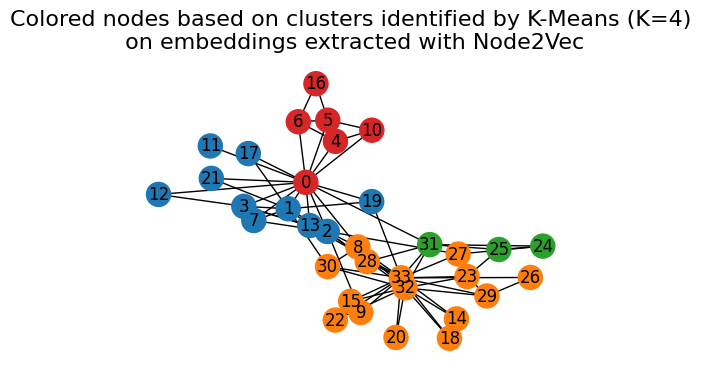

In [46]:
node_embedding_method_example(G, Node2Vec(dimensions=16))

Okay, so now I have the graph embedding, what can I do with it?

> The following part is an adaptation of a [tutorial](https://karateclub.readthedocs.io/en/latest/notes/introduction.html#graph-embedding) from the [Karate Club](https://karateclub.readthedocs.io/en/latest/index.html#) library

In [47]:
from karateclub.dataset import GraphSetReader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [48]:
def split_and_fit_logistic_and_print_aoc(
    X: np.ndarray,
    y: np.ndarray,
    test_size: Union[int, float] = 0.2,
    seed: Optional[int] = 42
) -> None:

    print("Splitting the data:")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

    print(
        f"- X_train shape: {X_train.shape}\n- X_test shape: {X_test.shape}"
        f"\n- y_train shape: {y_train.shape}\n- y_test shape: {y_test.shape}"
    )

    print("\nFitting a logistic regression")
    downstream_model = LogisticRegression(random_state=seed).fit(X_train, y_train)
    y_hat = downstream_model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_hat)
    print(f"\nArea Under the ROC curve (AUC): {auc:.4f}")

In [49]:
reader = GraphSetReader("reddit10k")
graphs = reader.get_graphs()
y = reader.get_target()
number_of_graphs = len(graphs)
print("There are {} graphs in this dataset".format(number_of_graphs))

There are 10000 graphs in this dataset


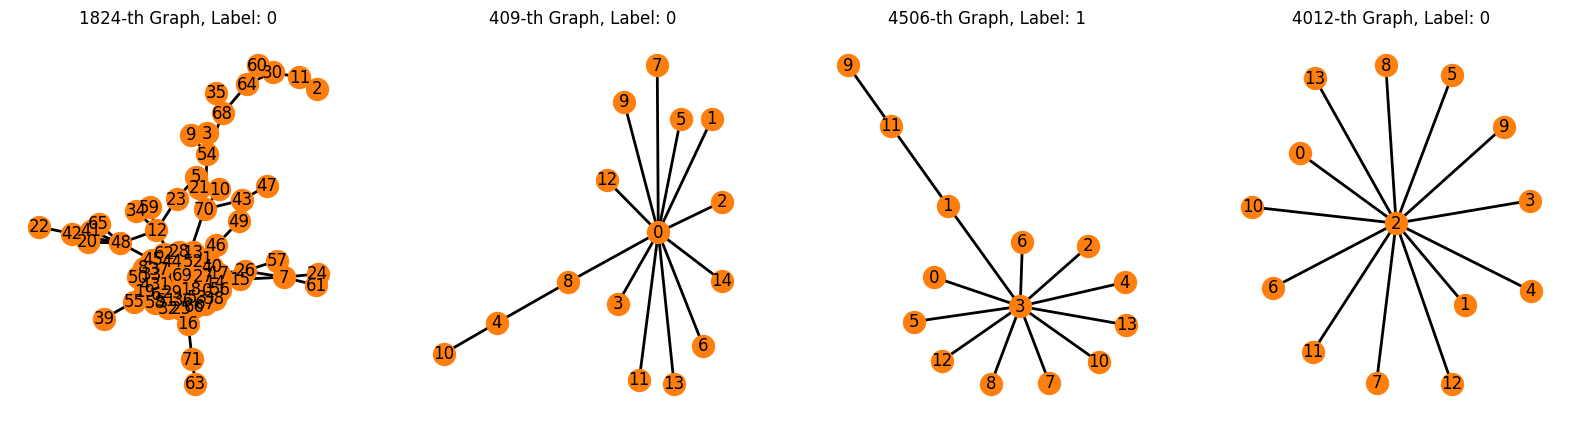

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
random_graph = random.sample(range(number_of_graphs), 4)
ax[0].set_axis_off()
ax[0] = fig.add_subplot(1, 4, 1)
ax[0].set_title("{}-th Graph, Label: {}".format(str(random_graph[0]), y[random_graph[0]]))
nx.draw(graphs[random_graph[0]], node_color="tab:orange", node_size=250, width=2, with_labels=True, ax=ax[0])
ax[1].set_axis_off()
ax[1] = fig.add_subplot(1, 4, 2)
ax[1].set_title("{}-th Graph, Label: {}".format(str(random_graph[1]), y[random_graph[1]]))
nx.draw(graphs[random_graph[1]], node_color="tab:orange", node_size=250, width=2, with_labels=True, ax=ax[1])
ax[2].set_axis_off()
ax[2] = fig.add_subplot(1, 4, 3)
ax[2].set_title("{}-th Graph, Label: {}".format(str(random_graph[2]), y[random_graph[2]]))
nx.draw(graphs[random_graph[2]], node_color="tab:orange", node_size=250, width=2, with_labels=True, ax=ax[2])
ax[3].set_axis_off()
ax[3] = fig.add_subplot(1, 4, 4)
ax[3].set_title("{}-th Graph, Label: {}".format(str(random_graph[3]), y[random_graph[3]]))
nx.draw(graphs[random_graph[3]], node_color="tab:orange", node_size=250, width=2, with_labels=True, ax=ax[3])
plt.show()

In [51]:
# The task is the classification of threads from the online forum Reddit. The threads can be of of two types -
# discussion and non-discussion based ones. Our goal is to predict the type of the thread based on the topological
# (structural) properties of the graphs. The specific dataset that we look a 10 thousand graph subsample of the Reddit
# 204K dataset which contains a large number of threads from the spring of 2018. The graphs in the dataset do not have
# a specific feature.

reader = GraphSetReader("reddit10k")
limit = 1000
graphs = reader.get_graphs()[:limit]
y = reader.get_target()[:limit]

# Approach 1

\begin{equation}
    G_{j} = \sum_{i=1}^{N} x_{ij}
\end{equation}

## Task: Compute Graph Embeddings Using the "Sum" Approach

In this task, you are required to compute the **graph embeddings** for a set of graphs using the **DeepWalk** model. After fitting the model to each graph, you will generate the embeddings and compute a final graph embedding by **summing** over the node embeddings for each graph.

### Steps:

1. **Graph Embedding**:
   - For each graph \( G \), you will use the `DeepWalk` algorithm to learn **node embeddings**.
   - The embeddings for each graph should be summed across all nodes to produce a single embedding that represents the entire graph.
   - The `get_graph_embedding` function will be used to fit the model to the graph and return the summed embedding vector.

2. **DeepWalk**:
   - You will use the `DeepWalk` model to generate node embeddings for the graph with a dimensionality of 16.
   - The `fit` method of the model is called to learn embeddings from the graph structure.
   - Once the embeddings are learned, they will be summed using `.sum(axis=0)` to produce a single vector representing the graph.

3. **Embedding Matrix**:
   - For each graph in the dataset, compute the summed graph embedding and store it in a matrix.
   - The embeddings for all graphs will be vertically stacked to form a matrix \( X \), where each row corresponds to the embedding of a graph.

### Specifications:

- **Input**: A dataset of graphs (`graphs`), where each graph is represented as a `networkx.Graph` object.
- **Model**: Use `DeepWalk(dimensions=16)` as the model to generate the node embeddings for each graph.
- **Output**: A matrix \( X \) containing the graph embeddings for all graphs in the dataset.


In [52]:
def get_graph_embedding(G: nx.Graph, model: Estimator) -> np.ndarray:
    """
    Compute the embedding of a graph G by fitting the model 
    and returning the sum of node embeddings.
    
    Parameters:
    G (nx.Graph): The graph to embed.
    model (Estimator): The embedding model (e.g., DeepWalk).
    
    Returns:
    np.ndarray: The summed embedding vector for the graph.
    """
    # Fit the model to the graph
    
    # Return the summed embedding of the graph
    return ...

# Print a message indicating the start of the embedding computation
print('Computing the graph embedding for each graph in the dataset using the "sum" approach')

# Generate the embeddings for all graphs in the dataset and store them in X
X = np.vstack([get_graph_embedding(G, DeepWalk(dimensions=16)) for G in graphs])


In [54]:
print("Dimension of the embedding matrix: {}".format(X.shape))

Dimension of the embedding matrix: (1000, 16)


In [55]:
split_and_fit_logistic_and_print_aoc(X, y)

Splitting the data:
- X_train shape: (800, 16)
- X_test shape: (200, 16)
- y_train shape: (800,)
- y_test shape: (200,)

Fitting a logistic regression

Area Under the ROC curve (AUC): 0.6622


# Approach 2

Add a virtual node $u_{\text{virtual}}$ to the original graph

\begin{equation}
   V \mapsto V \cup \lbrace u_{\text{virtual}} \rbrace
   \quad
   \text{and}
   \quad
   E \mapsto E \cup \lbrace (v, u_{\text{virtual}}) : v \in G \rbrace
\end{equation}

and retrieve the contributions of the graph to that virtual node

## Task: Compute Graph Embeddings Using the "Virtual Node" Approach

In this task, you will compute graph embeddings by adding a **virtual node** to each graph. The virtual node is connected to all existing nodes in the graph, and the final graph embedding will be the embedding of this virtual node. This approach allows you to capture the contributions of all nodes in the graph to a single virtual node, which can serve as a summary for the entire graph.

### Steps:

1. **Add a Virtual Node**:
   - For each graph \( G \), add a new virtual node u_{\text{virtual}} to the set of nodes.
   - Connect the virtual node to **all nodes** in the graph. This ensures that the virtual node has access to all the information in the graph.

2. **Graph Embedding**:
   - Use the `DeepWalk` model to generate node embeddings after the virtual node is added.
   - The embedding of the virtual node \( u_{\text{virtual}} \) will be used as the **graph embedding**, as it integrates contributions from all other nodes.

3. **Embedding Matrix**:
   - For each graph in the dataset, compute the graph embedding by retrieving the embedding of the virtual node and store it in a matrix.
   - The embeddings for all graphs will be vertically stacked to form a matrix \( X \), where each row corresponds to the embedding of a graph.

### Specifications:

- **Input**: A dataset of graphs (`graphs`), where each graph is represented as a `networkx.Graph` object.
- **Virtual Node**: A new node is added to each graph and connected to all existing nodes.
- **Model**: Use `DeepWalk(dimensions=16)` to generate node embeddings.
- **Output**: A matrix \( X \) containing the graph embeddings for all graphs in the dataset, where the embedding for each graph is the embedding of the virtual node.


In [ ]:
def get_graph_embedding(G: nx.Graph, model: Estimator) -> np.ndarray:
    """
    Compute the embedding of a graph G by adding a virtual node
    and returning the embedding of the virtual node.
    
    Parameters:
    G (nx.Graph): The graph to embed.
    model (Estimator): The embedding model (e.g., DeepWalk).
    
    Returns:
    np.ndarray: The embedding vector for the virtual node, which serves as the graph embedding.
    """
    # Create a copy of the graph
   
    
    # List of existing nodes in the graph
    
    # Create a virtual node with an ID greater than any existing node
    
    # Add the virtual node to the graph
    
    # Connect the virtual node to all existing nodes
    
    # Fit the model to the modified graph
    
    # Return the embedding of the virtual node (the last node in the embedding matrix)
    return 

# Print a message indicating the start of the embedding computation
print('Computing the graph embedding for each graph in the dataset using the "virtual node" approach')

# Generate the embeddings for all graphs in the dataset and store them in X
X = np.vstack([get_graph_embedding(G, DeepWalk(dimensions=16)) for G in graphs])

In [58]:
split_and_fit_logistic_and_print_aoc(X, y)

Splitting the data:
- X_train shape: (800, 16)
- X_test shape: (200, 16)
- y_train shape: (800,)
- y_test shape: (200,)

Fitting a logistic regression

Area Under the ROC curve (AUC): 0.7133


# Approach 3

Kernel based-methods like [AnonymousWalkKernel](https://arxiv.org/pdf/1805.11921.pdf)

In [59]:
!git clone https://github.com/nd7141/AWE.git

%cd AWE

!git checkout fc4d3c4d180e5793d6cd4ba9235889067039d038

from AnonymousWalkKernel import AnonymousWalks

%cd ..
%rm -rf AWE

Cloning into 'AWE'...
remote: Enumerating objects: 515, done.
remote: Total 515 (delta 0), reused 0 (delta 0), pack-reused 515
Receiving objects: 100% (515/515), 2.38 MiB | 13.40 MiB/s, done.
Resolving deltas: 100% (338/338), done.
/content/AWE
Note: switching to 'fc4d3c4d180e5793d6cd4ba9235889067039d038'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at fc4d3c4 Fix setup for FB parameters
/content


## Task: Compute Graph Embeddings Using the "Anonymous Walk" Approach

In this task, you will compute graph embeddings for a set of graphs using the **Anonymous Walks** method. Anonymous walks capture the structural patterns in a graph without keeping track of the exact node identities, focusing on the **structural equivalence** of the walks. The embeddings are generated by counting different walk patterns within the graph.

### Steps:

1. **Anonymous Walks**:
   - For each graph \( G \), you will use the **Anonymous Walks** method to generate an embedding.
   - An **anonymous walk** captures the structure of a walk without considering the specific node identities, focusing only on the sequence of roles nodes play during the walk.
   - The embedding is based on how often each **anonymous walk pattern** appears in the graph for a given number of steps.

2. **Graph Embedding**:
   - You will use the `AnonymousWalks` class to generate embeddings by counting the different anonymous walk patterns in each graph.
   - The number of steps \( num\_steps \) controls the length of the anonymous walks (how far you explore the graph).

3. **Embedding Matrix**:
   - For each graph in the dataset, compute the anonymous walk embedding and store it in a matrix.
   - The embeddings for all graphs will be vertically stacked to form a matrix \( X \), where each row corresponds to the embedding of a graph.

### Specifications:

- **Input**: A dataset of graphs (`graphs`), where each graph is represented as a `networkx.Graph` object.
- **Anonymous Walks**: Use the `AnonymousWalks` method to generate the embeddings based on the structural patterns in the graph. You will use 3 steps for the anonymous walks.
- **Output**: A matrix \( X \) containing the graph embeddings for all graphs in the dataset, based on the anonymous walk patterns.


In [ ]:
import random
import networkx as nx
import numpy as np
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

def get_random_walk(node, G, walk_length):
    # Implement a function that generates a random walk starting from 'node'
    # The walk should be of length 'walk_length'
    # At each step, randomly select a neighbor to continue the walk
    # If a node has no neighbors, break the loop
    return random_walk

def anonymous_walk(walk):
    # Convert a walk into its anonymous representation
    # Assign a unique label to each new node encountered in the walk
    # Return the anonymous walk as a tuple of labels
    return tuple(anon_walk)

def get_anonymous_walk_counts(G, walk_length=5, num_walks=10):
    # Generate a random walk starting from 'node'
    # Convert the walk into its anonymous representation
    # Update 'anon_walk_counts' with the anonymous walk
    return anon_walk_counts # A counter of objects of the anno_walks

def compute_anonymous_walk_embeddings(graphs, walk_length=5, num_walks=10):
    anon_walk_counts_list = []
    for G in tqdm(graphs):
        # Compute anonymous walk counts for each graph
        anon_walk_counts = get_anonymous_walk_counts(G, walk_length, num_walks)
        # Append the counts to 'anon_walk_counts_list'
        anon_walk_counts_list.append(anon_walk_counts)
    # Use DictVectorizer to convert counts into feature vectors
    vec = DictVectorizer(sparse=False)
    X = vec.fit_transform(anon_walk_counts_list)
    return X


print('Computing the graph embedding for each graph in the dataset using the anonymous walk approach')

X = compute_anonymous_walk_embeddings(graphs, walk_length=5, num_walks=10)

In [ ]:

split_and_fit_logistic_and_print_aoc(X, y)

## Compare with the method from the library

In [60]:
def get_graph_embedding(G: nx.Graph, num_steps: int = 3) -> np.ndarray:
    embedding = AnonymousWalks(G=G).embed(steps=num_steps, verbose=False)[0]
    return np.asarray(embedding)


print('Computing the graph embedding for each graph in the dataset using the "Anonymous Walk" approach')
X = np.vstack([get_graph_embedding(G)for G in tqdm(graphs)])

In [61]:

split_and_fit_logistic_and_print_aoc(X, y)

Computing the graph embedding for each graph in the dataset using the "Anonymous Walk" approach


  0%|          | 0/1000 [00:00<?, ?it/s]

Splitting the data:
- X_train shape: (800, 7)
- X_test shape: (200, 7)
- y_train shape: (800,)
- y_test shape: (200,)

Fitting a logistic regression

Area Under the ROC curve (AUC): 0.7831
